Notebook belonging to the article about Change detection of Night-Time Light Intensities after the Beirut 2020 Explosion

<h1> Data Setup </h1>
Hardcoded links to the local files

* provide links to relevant datasets on GitHub

In [1]:
#set data sources:
mapDataPath = r"E:\Projects\NTL_Beirut_DATA"

pathShapeFile = r"E:\Projects\NTL_Beirut_DATA\gadm36_LBN_shp"
gadm36_LBN_0 = r"E:\Projects\NTL_Beirut_DATA\gadm36_LBN_shp\gadm36_LBN_0.shp"
gadm36_LBN_3 = r"E:\Projects\NTL_Beirut_DATA\AoI_mainA3b2.shp"
#admFile0 = "gadm36_LBN_0.shp"
admFile = "gadm36_LBN"
extention = "shp"

fileAoI_main= "AoI_main.shp"
fileAoI_mainA3 = "AoI_mainA3.shp"

# the path to a default raster to obtain file caracteristics (extent, cell size, projection)
check_raster = r"E:\Projects\NTL_Beirut_DATA\batch0\3_NewGeoTiff\VNP46A2_A2021035_h21v05_001_2021104055003.tif"

#Night-Time Light Data links:
pathDataRepo = r"E:\Projects\NTL_Beirut_DATA\batch0"
pathOrg_H5 = "1_OrgVNP46A2"
pathRawTiff = "2_RawGeoTiff"
pathNewTiff = "3_NewGeoTiff"



<h1> Libraries </h1>
There are four types of libraries used in this project:

1. general system libraries
2. plotting libraries
3. data handling libraries, and 
4. geospatial libraries

Most of the libraries are installing easily, but it is recommended to create a special geo-spatial environment with geopandas, when creating the environment the libraries listed here will install on top of this packages.

In [2]:
#!pip install tilemapbase #OSM tile server
import tilemapbase

import os
import datetime
import math
import statistics as stat

import matplotlib.pyplot as plt
from matplotlib.path import Path

import matplotlib.patches as patches
from matplotlib.patches import Patch

import matplotlib.colors as color
from matplotlib.colors import ListedColormap, BoundaryNorm

import seaborn as sns

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import xarray as xr

from osgeo import gdal, ogr, gdalnumeric
import fiona
from shapely.geometry import shape
import rasterio
import rasterio.mask
from rasterio.crs import CRS
from rasterio.plot import reshape_as_raster, reshape_as_image

import rioxarray as rxr
#import earthpy as et

<h1> Functions </h1>

1. roundint
2. tickrange
3. setExtentDetailedMap
4. getRasterPoint
5. createPolygon
6. conJDtoDate
7. getDayOfYear
8. constructTimeRange
9. getRasterData
10. createCumSumNTL
11.


<h3> F1. roundint</h3>

In [3]:
###----------------------------------------------------------------------###
# roundint                                                                 #
###                                                                      ###  
# simple rounding function to calculate the nearest integer value          #
###                                                                      ###
# value: the input value                                                   #
# base:  rounding the the first nth decimal position (0, 10, 100, 1000)    #
# direction: "neg", rounding down / "pos", rounding up                     #
#            test rounds to the nearest base                               #
###                                                                      ###
# return: rounded value                                                    #
###----------------------------------------------------------------------###


def roundint(value, base, direction="neg"):
    
    rounded = int(value) - int(value) % base
    
    if direction == "pos" :
        rounded = rounded + base
        
    elif direction == "test" :
        rounded_neg = rounded
        rounded_pos = rounded + base
        
        t1 = value - rounded_neg
        t2 = rounded_pos - value
        
        if t1 > t2:
            rounded = rounded_pos
            
    
    return rounded

In [4]:
#print(roundint(710, 100, direction="test"))

<h3> F2. tickrange </h3>

In [5]:
###----------------------------------------------------------------------###
# tickrange                                                                #
###                                                                      ###  
# When creating maps the figure are looking better with clear, rounded     #
# ticks at the border, this function is taking the extent of the map and   #
# calculate the range for the map                                          #
###                                                                      ###
# min_val: minumum coordinate (x/y)                                        #
# max_val: maximum coordinate (x/y)                                        #
# base:    depending on the coordinate system a different precision is     #
#          needed                                                          #
###                                                                      ###
# return: the tick range for the graph                                     #
###----------------------------------------------------------------------###


def tickrange(min_val, max_val, base):
              
    min_val = roundint(min_val, base)
    pos_val = roundint(max_val, base, direction="pos")
    
    #print(min_val, pos_val)
    
    tickrange = np.arange(min_val, pos_val, base)
    
    return tickrange


<h3> F3. setExtentDetailedMap </h3>

In [6]:
###----------------------------------------------------------------------###
# setExtentDetailedMap                                                     #
###                                                                      ###  
# Setting the extent for the detailed map based on the coordinates         #
# This function is fixed on the "EPSG:3857" to work with the OSM data      #
# Possible improvement is to give the EPSG code as input                   #
###                                                                      ###
# input coordinates:
# miny3c, maxy3c, minx3c, maxx3c                                           #
###                                                                      ###
# return: map_extent                                                       #
###----------------------------------------------------------------------###


def setExtentDetailedMap(miny3c, maxy3c, minx3c, maxx3c):
    df_extent = pd.DataFrame(
        {'point': ["min", "max"],
         'Description': ["lower left corner", "upper right corner"],
         'Latitude': [miny3c, maxy3c],
         'Longitude': [minx3c, maxx3c]})

    gdf_extent = gpd.GeoDataFrame(
        df_extent, geometry=gpd.points_from_xy(df_extent.Longitude, df_extent.Latitude))

    gdf_extent.set_crs("EPSG:3857", inplace=True)

    map_extent = tilemapbase.extent_from_frame(gdf_extent, buffer = 25)
    map_extent = map_extent.to_aspect(1.0)
    #print(extent2)
    #print(extent3)
    return map_extent


<h3>F4. getRasterPoint</h3>

In [7]:
###----------------------------------------------------------------------###
# getRasterPoint                                                           #
###                                                                      ###  
# calculate the coordinate of the raser cell based of an user generated    #
# coordinate, this point is used to draw the boxes on the map figures      #
# to show the area around the selected locations                           #
###                                                                      ###
# inputRaster: the target raster (NTL converted geotiff)                   #
# lat:         user latitude coordinate (y)                                #
# lon:         user longitude coordinate (x)                               #
###                                                                      ###
# return: lat, lon                                                         #
###----------------------------------------------------------------------###


def getRasterPoint(inputRaster, lat, lon):
#test = True

#if test:
    #window = 1
    #inputRaster = r"E:/Projects/NTL_Beirut_DATA/batch2/GeoTIFF/VNP46A2_A2020217VNP46A2.A2020217.h21v05.001.2021076031729_BBOX.tif"
    
    raster = gdal.Open(inputRaster,gdal.GA_ReadOnly)
    if raster is None:
        print ("Could not open image " , content[NOF])
        #sys.exit(1)

    band = raster.GetRasterBand(1)

    cols = raster.RasterXSize
    rows = raster.RasterYSize
    
    transform = raster.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    
    #print(xOrigin, yOrigin)
    
    pixelWidth = transform[1]
    pixelHeight = -transform[5]
    data = band.ReadAsArray(0, 0, cols, rows)

    col = int((lon - xOrigin) / pixelWidth )
    row = int((yOrigin - lat) / pixelHeight)
    
    lon = (col * pixelWidth) + xOrigin
    lat = yOrigin - (row * pixelHeight)
    
    return lat, lon

<h3> F5. createPolygon </h3>

In [8]:
###----------------------------------------------------------------------###
# createPolygon                                                            #
###                                                                      ###  
# construct the polygons on the map, based on user selected points         #
# NTL_cell: the representation of one raster cell                          #
# NTL_area: the 3x3 window around the selected point                       #
###                                                                      ###
# label:        the name of the point                                      #
# lat:          user latitude coordinate (y)                               #
# lon:          user longitude coordinate (x)                              #
# check_raster: the target raster                                          #
###                                                                      ###
# return: NTL_cell, NTL_area                                               #
###----------------------------------------------------------------------###

def createPolygon(label, lat, lon, check_raster):

    #check_raster #= r"E:\Projects\NTL_Beirut_DATA\batch0\3_NewGeoTiff\VNP46A2_A2021035_h21v05_001_2021104055003.tif"

    #return uper left corner of the grid
    lat_new, lon_new = getRasterPoint(check_raster, lat, lon)
        
    df = pd.DataFrame({'PoI':label,
                       'Lat':[lat_new],
                       'Lon':[lon_new]})

    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Lon, df.Lat))

    gdf.set_crs("EPSG:4326", inplace=True)
    gdf = gdf.to_crs("EPSG:3857") #new projection, to work with OSM
    
    # ULC -> URC -> LRC -> LLC -> ULC -> close 
    x1 = float(gdf.geometry.x)
    y1 = float(gdf.geometry.y)

    side1 = 516
    minx = x1
    miny = y1 - side1
    maxx = x1 + side1
    maxy = y1     
    
    verts1 = [(minx, miny),  # left, bottom
             (minx, maxy),  # left, top
             (maxx, maxy),  # right, top
             (maxx, miny),  # right, bottom
             (minx, maxy),] # ignored

    codes1 = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY,]
    
    verts2 = [(minx-side1, miny-side1),  # left, bottom
             (minx-side1, maxy+side1),  # left, top
             (maxx+side1, maxy+side1),  # right, top
             (maxx+side1, miny-side1),  # right, bottom
             (minx-side1, maxy-side1),] # ignored

    codes2 = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY,]

    NTL_cell = Path(verts1, codes1)
    NTL_area = Path(verts2, codes2)
    
    return NTL_cell, NTL_area


<h3> F6. conJDtoDate</h3>

In [9]:
###----------------------------------------------------------------------###
# conJDtoDate                                                              #
###                                                                      ###  
# conversion function for Julian Date (JD) to real date, the GeoTiff       #
# files have the year and the day number in the filename, this function    #
# is extracting the date out of the name                                   #
###                                                                      ###
# JD:Julian Date                                                           #
###                                                                      ###
# return: date                                                             #
###----------------------------------------------------------------------###

def conJDtoDate(JD):
    date = datetime.datetime.strptime(JD, '%y%j').date()
    return date

<h3> F7. getDayOfYear</h3>

In [10]:
###----------------------------------------------------------------------###
# getDayOfYear                                                             #
###                                                                      ###  
# conversion function to calculate the Julian Date from a date sting       #
# format = "%Y-%m-%d %H:%M:%S"                                             #
# s = "2016-08-04 00:00:00"                                                # 
# tm_yday = range [1, 366]                                                 #
###                                                                      ###
# strDate: Date                                                            #
###                                                                      ###
# return: intDay                                                           #
###----------------------------------------------------------------------###


def getDayOfYear(strDate): 
    format = "%Y-%m-%d %H:%M:%S"
    dt = datetime.datetime.strptime(s, format)

    tt = dt.timetuple()
    intDay = tt.tm_yday
    
    return intDay

<h3> F8. onstructTimeRange</h3>

In [11]:
###----------------------------------------------------------------------###
# constructTimeRange                                                       #
###                                                                      ###  
# creating a list of dates from the raster files names between a selected  #
# time ranges (days), either as a single date, historical, or full period  #
###                                                                      ###
# rasterFiles: list of all converted NTL files as GeoTiff on the local     #
#              file system                                                 #
# date_Start:  first day of interest                                       #
# date_Stop:   last day of interest                                        #
# list_type:   "single" / "historical" / "all"                             #
###                                                                      ###
# return: intDay                                                           #
###----------------------------------------------------------------------###
# todo: make the function available for when the files are not on the 
#       local system

def constructTimeRange(rasterFiles, date_Start, date_Stop, list_type):
    #get a list of files
    arr = np.array(rasterFiles)
    df = pd.Series(arr)
    days =df.str[11:16]

    JD = []
    for i in range(0, len(days)):
        dateOfYear = conJDtoDate(days[i])
        JD.append(dateOfYear)
        
    df_JD = pd.Series(JD)

    df_filelist = pd.DataFrame(df)
    df_filelist['dates'] = pd.DataFrame(df_JD)
    df_filelist.rename(columns={0: 'filenames'}, inplace=True)
    
    if list_type == "single":
    
        #date_string = "2020-08-01"
        from_date = datetime.date.fromisoformat(date_Start)

        #date_string = "2020-10-31"
        to_date = datetime.date.fromisoformat(date_Stop)
        
        selectedDates = df_filelist[(df_filelist['dates'] >= from_date) & (df_filelist['dates'] <= to_date)]
        print(selectedDates)
    
    else: #historical or all
        #data is gathered from 05/01 to 10/31 for years between 2015 - 2019
        selectedDatesYear = []
        if list_type == "historical":
            years = range(2015, 2020) #range is not creating 2020
        else:
            years = range(2015, 2021) #range is not creating 2021

        for year in years:
            #date_string = "2020-08-01"
            #print(year)
            date_Start = str(year) + date_Start[-6:]
            date_Stop = str(year) + date_Stop[-6:]
            
            from_date = datetime.date.fromisoformat(date_Start)
            to_date = datetime.date.fromisoformat(date_Stop)
            
            result = (df_filelist[(df_filelist['dates'] >= from_date) & (df_filelist['dates'] <= to_date)])

            selectedDatesYear.append(result)
            
        selectedDates = pd.concat(selectedDatesYear, ignore_index=True)       

    return selectedDates

<h3>F9. getRasterData</h3>

In [12]:
###----------------------------------------------------------------------###
# getRasterData                                                            #
###                                                                      ###  
# creating a list of dates from the raster files names between a selected  #
# time ranges (days), either as a single date, historical, or full period  #
###                                                                      ###
# inputRaster: the target raster                                           #
# lat:         the user selected latitude (y)                              #
# lon:         the user selected longitude (x)                             #
# window:      either 1 (single cell), or 3 (area)                         #
###                                                                      ###
# return: value; the NTL of the cell or the average of the area            #
###----------------------------------------------------------------------###
# note: converted function from the ARSET training


def getRasterData(inputRaster, lat, lon, window):
#test = True
    
    raster = gdal.Open(inputRaster,gdal.GA_ReadOnly)
    if raster is None:
        print ("Could not open image " , content[NOF])
        #sys.exit(1)

    band = raster.GetRasterBand(1)

    cols = raster.RasterXSize
    rows = raster.RasterYSize
    
    transform = raster.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    
    pixelWidth = transform[1]
    pixelHeight = -transform[5]
    data = band.ReadAsArray(0, 0, cols, rows)

    col = int((lon - xOrigin) / pixelWidth )
    row = int((yOrigin - lat) / pixelHeight)
    
#Data AT THAT ROW COLUMN
    if(window == 3):
        #print(window)
        indexX = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
        indexY = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
        newIndexX = indexX + row
        newIndexY = indexY + col
        
        Toalvalue = []
        for i in range(0, 3):
            for j in range(0, 3):
                Toalvalue.append(data[newIndexX[i][j]][newIndexY[i][j]])
                
        value = format(stat.mean(map(float, Toalvalue)),'.2f')
        
        if float(value) > 10000:
            value = 0
        elif float(value) > 5000:
            value = 5000
        
        return float(value)

    else:
        
        value = data[row][col]
        
        if value > 10000:
            value = 0
        elif value > 5000:
            value = 5000
            
        return value


<h3>F10. createCumSumNTL</h3>

In [13]:
###----------------------------------------------------------------------###
# createCumSumNTL                                                          # 
###                                                                      ###
# creating the cummulative sum of all night time light intensities         #
# in an boundary (shapefile) by raster cell, as input for a graph          #
###                                                                      ###
# boundary_shape: boundary file (e.g. gadm36_LBN_3/0)                      #
# rasterFiles: geotiff file name list                                      #
# outputFolder: root location at files                                     #
###                                                                      ###
# return: df_sum_NTL dataframe with the cummulative count of all the       # 
#         unique NTL values on the cells in the target area, and the ratio #
#         (sum of the NTL count / total sum of NTL value                   #
###----------------------------------------------------------------------###


def createCumSumNTL(boundary_shape, outputFolder, rasterFiles):

    with fiona.open(boundary_shape, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    rasterFiles.sort()
    totalFiles = len(rasterFiles)

    # create the summed NTL list
    sum_NTL= np.zeros(1)

    for i in range(0, totalFiles):

        rasterFilesLoc_tmpA = os.path.join(outputFolder, rasterFiles[i])

        with rasterio.open(rasterFilesLoc_tmpA) as src:
            out_imageA, out_transform = rasterio.mask.mask(src, shapes, crop=True)

        imageA = reshape_as_image(out_imageA)
        image2A = ma.where((imageA > 0) & (imageA < 20000), imageA, np.nan)
        out_image2A = reshape_as_raster(image2A)
        
        #removing all converted nan values, bincount can't have negative numbers
        a1 = np.array(out_image2A[0,:,:][out_image2A[0,:,:]>0])
        b1= a1.flatten().astype(int)
        test_countA=np.bincount(b1) #counts all unique values in a continuous list [0-n]
        #test_countA.shape

        if sum_NTL.shape < test_countA.shape:
            in_arr1 = sum_NTL
            in_arr2 = test_countA
        else:
            in_arr2 = sum_NTL
            in_arr1 = test_countA

        # making the two arrays match in dimentions 
        shape = np.shape(in_arr1)
        padded_array = np.zeros(in_arr2.shape)
        padded_array[:shape[0]] = in_arr1
        #print(padded_array)

        sum_NTL = np.add(padded_array, in_arr2) 
        #print ("output added array : ", out_arr) 
   
    #All tiles are clipped and the NTL summed
    df_sum_NTL = pd.DataFrame(sum_NTL)
    df_sum_NTL['index1'] = df_sum_NTL.index
    df_sum_NTL.rename(columns={df_sum_NTL.columns[0]: 'count'}, inplace=True)
    
    df_sum_NTL['cumsum'] = np.cumsum(df_sum_NTL['count'])
    df_sum_NTL['ratio'] = df_sum_NTL['cumsum']/df_sum_NTL['cumsum'].max()

    df_sum_NTL #.groupby(['quantilev2'], sort=False)['count'].max()

    # input for the ratio plot
    return df_sum_NTL
        


<h1> Creating the graphs </h1>

1. Project Domain
2. Selected Locations
3. Cumulative Contribution Night-Time Light (NTL) Intensity <br>
   a. Lebanon <br>
   b. Greater Beirut Area <br>
4. NTL intensity directly after the explosion
5. Night-Time Light (NTL) by Site
6. Night-Time Light (NTL) by Site and Year
7. Blast Site by year
8. NTL for all sites in 2020

<h2> Project Domain </h2>
Showing the extent, starting with the NTL raster extent, Lebanon, and the Greater Beirut Area

In [14]:
# Load the map layers and set the extents
#NTL = 30, 30 : 40, 40
#minx, miny, maxx, maxy = gdf.total_bounds
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
s1 = 0.25
minx1a = 30
maxx1a = 40

lebanon = gpd.read_file(gadm36_LBN_0)  #native projection
lebanon2 = lebanon.to_crs("EPSG:3857") #new projection, to work with OSM
minx2a, miny2a, maxx2a, maxy2a = lebanon.geometry.total_bounds  # original
minx2b, miny2b, maxx2b, maxy2b = lebanon2.geometry.total_bounds # reprojected

beirut = gpd.read_file(os.path.join(mapDataPath, fileAoI_main))
beirut.set_crs("EPSG:4326", inplace=True)
beirut2 = beirut.to_crs("EPSG:3857")
minx3a, miny3a, maxx3a, maxy3a = beirut.geometry.total_bounds  # original
minx3b, miny3b, maxx3b, maxy3b = beirut2.geometry.total_bounds # reprojected


In [15]:
#https://geohack.toolforge.org/geohack.php?pagename=2020_Beirut_explosion&params=33_54_05_N_35_31_09_E_region:LB_type:event

#Set the points, need a new structure (gpd), to add a label
#Latitude is y and Longitude is x
#Point 1: blast site
name1 = "Blast Site"
#x=35.519167, y=33.901389 // , 
pnt_lon1 = 35.519167
pnt_lat1 = 33.901389

#Point 2: airport
#x=35.493602,y=33.827401
name2 = "Airport"
pnt_lon2 = 35.493602
pnt_lat2 = 33.827401

#Point 1: Residential 1
name3 = "Residential 1"
#x=35.520880,y=33.891832
#35.523767,33.893904
pnt_lon3 = 35.523767
pnt_lat3 = 33.893904

#Point 2: Residential 2
name4 = "Residential 2"
#x=35.480420,y=33.895347
#35.480167,33.894643
pnt_lon4 = 35.480167
pnt_lat4 = 33.894643

#Point 1: Port 1
#x=35.534573,y=33.904379
#35.535168,33.902527
name5 = "Port 1"
pnt_lon5 = 35.535168
pnt_lat5 = 33.902527

#Point 2: Port 2
#x=35.553013,y=33.898034
name6 = "Port 2"
pnt_lon6 = 35.553013
pnt_lat6 = 33.898034

df_points = pd.DataFrame(
    {'PoI': [name1, name2, name3, name4, name5, name6],
     'Description': [name1, name2, name3, name4, name5, name6],
     'Latitude': [pnt_lat1, pnt_lat2, pnt_lat3, pnt_lat4, pnt_lat5, pnt_lat6],
     'Longitude': [pnt_lon1, pnt_lon2, pnt_lon3, pnt_lon4, pnt_lon5, pnt_lon6]})

gdf_points = gpd.GeoDataFrame(
    df_points, geometry=gpd.points_from_xy(df_points.Longitude, df_points.Latitude))

gdf_points.set_crs("EPSG:4326", inplace=True)
gdf_points2 = gdf_points.to_crs("EPSG:3857") #new projection, to work with OSM
minx3c, miny3c, maxx3c, maxy3c = gdf_points2.geometry.total_bounds # reprojected

In [16]:
#add some margin (10%) around the second extent 
difx = maxx2b - minx2b
dify = maxy2b - miny2b

margin_x = difx/10
margin_y = dify/10

s2 = (margin_x + margin_y) / 2


#setting the extent of the third map, and
#the bounding box for the second map

if minx3b < minx3c:
    minx3c = minx3b

if miny3b < miny3c:
    miny3c = miny3b

if maxx3b > maxx3c:
    maxx3c = maxx3b

if maxy3b > maxy3c:
    maxy3c = maxy3b
    
#add some marging 1%
difx = maxx3c - minx3c
dify = maxy3c - miny3c

margin_x = difx/10
margin_y = dify/10

minx3c = minx3c - margin_x
miny3c = miny3c - margin_y

maxx3c = maxx3c + margin_x
maxy3c = maxy3c + margin_y

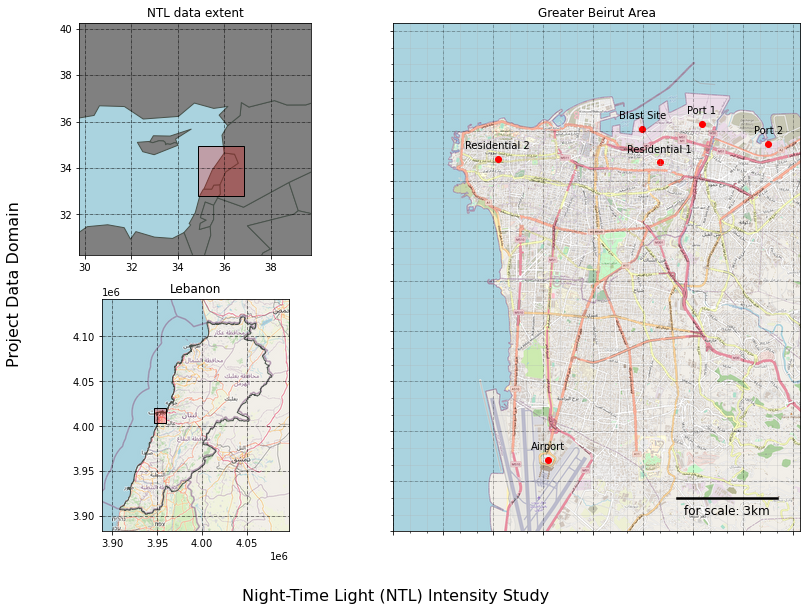

In [17]:
#https://github.com/matplotlib/cheatsheets/blob/master/cheatsheets-1.png
#https://rosenfelder.ai/create-maps-with-python/

#creating 3 maps in one figure
map1 = world
map2 = lebanon2 # reprojected
map3 = beirut2  # reprojected

border_color = [73/254, 82/254, 75/254, 1]
border_color = color.to_rgba(border_color)

fc=color.to_rgba('red', 0.0)


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
gs = axs[0, 1].get_gridspec()
# remove one the underlying axes
for ax in axs[0:, -1]:
    ax.remove()

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (1,0))
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)

# Set the limits for the first map
ax1.set_xlim(minx1a-s1, maxx1a-s1)
ax1.set_ylim(minx1a+s1, maxx1a+s1)

# Plot the first map
ax1.set_facecolor('#aad3df')
map1.plot(ax=ax1, color="grey", edgecolor=border_color, linewidths=1)

# Set the background tiling for the second map
tilemapbase.start_logging()
tilemapbase.init(create=True)
extent2 = tilemapbase.extent_from_frame(map2, buffer = 25)

plotter2 = tilemapbase.Plotter(extent2, tilemapbase.tiles.build_OSM(), width=250)
plotter2.plot(ax=ax2)

# Plot the second map
map2.plot(ax=ax2, color=fc, edgecolor=border_color, linewidths=1)
ax2.set_xlim(minx2b-s2, maxx2b+s2)
ax2.set_ylim(miny2b-s2, maxy2b+s2)

# Set the background tiling for the third map
extent3 = setExtentDetailedMap(miny3c, maxy3c, minx3c, maxx3c)
plotter3 = tilemapbase.Plotter(extent3, tilemapbase.tiles.build_OSM(), width=1000)
plotter3.plot(ax=ax3)

# Plot the third map
map3.plot(ax=ax3, color=fc, edgecolor=fc, linewidths=1) #full transparent
ax3.set_xlim(minx3c, maxx3c)
ax3.set_ylim(miny3c, maxy3c)


# Drawing the zoom rectangles:
#            left, bottom # left, top # right, top # right, bottom # ignored
s2a = 0.25 # in origianl projection (degree)
verts1 = [(minx2a-s2a, miny2a-s2a), (maxx2a+s2a, miny2a-s2a), 
          (maxx2a+s2a, maxy2a+s2a), (minx2a-s2a, maxy2a+s2a), (minx2a-s2a, miny2a-s2a),]  
          

codes2 = [Path.MOVETO, Path.LINETO, Path.LINETO,Path.LINETO, Path.CLOSEPOLY,]

fc=color.to_rgba('red', 0.25)
path = Path(verts1, codes2)
patch = patches.PathPatch(path, facecolor=fc, lw=1) #facecolor='r'
ax1.add_patch(patch)


# left, bottom  # left, top # right, top # right, bottom # ignored
# add even more margin for the little box to indenfy the project area
s3 = 1000
verts2 = [(minx3c-s3, miny3c-s3), (maxx3c+s3, miny3c-s3), 
          (maxx3c+s3, maxy3c+s3), (minx3c-s3, maxy3c+s3), (minx3c-s3, miny3c-s3),]  

codes2 = [Path.MOVETO, Path.LINETO, Path.LINETO, path.LINETO, Path.CLOSEPOLY,]

path = Path(verts2, codes2)
patch = patches.PathPatch(path, facecolor=fc, lw=1)
ax2.add_patch(patch)

#add the points on the map
gdf_points2.plot(ax=ax3, alpha = 1, color="red")

#zip is unpacking in iteration, so that the pair x,y can be used to label with PoI
for x, y, label in zip(gdf_points2.geometry.x, gdf_points2.geometry.y, gdf_points2.PoI):
    ax3.annotate(label, xy=(x, y), xytext=(0, 10), textcoords="offset points",
                ha='center')

    
# Some more formatting
# set the tick ranges for map 3
base = 1500
major_ticksX=tickrange(minx3c, maxx3c, base)
major_ticksY=tickrange(miny3c, maxy3c, base)

minor_ticksX=tickrange(minx3c, maxx3c, base/3)
minor_ticksY=tickrange(miny3c, maxy3c, base/3)

ax3.grid(which="major",alpha=0.6)
ax3.grid(which="minor",alpha=0.3)

ax3.set_xticks(major_ticksX)
ax3.set_yticks(major_ticksY)
ax3.set_xticks(minor_ticksX, minor=True)
ax3.set_yticks(minor_ticksY, minor=True)

#removing the tick labels for map3
ax3.set_xticklabels([])
ax3.set_yticklabels([])

titles = ['NTL data extent', 'Lebanon', 'Greater Beirut Area']

for i, ax in enumerate(fig.axes):
    column = titles[i]
    
    ax.set_title(column) #, fontsize='small', loc='left')
    ax.grid(True, color = "black", linewidth = "0.5", linestyle = "-.")
    
#drawning a horizontal 3km line for scale
endX = roundint(maxx3c, base) - 500
startX = endX - 3000
startY = roundint(miny3c, base) + 1000

x_coordinates = [startX, endX]
y_coordinates = [startY, startY]

ax3.plot(x_coordinates, y_coordinates, color = "black", linewidth = "2.5")

label = "for scale: 3km"
x_value = (startX + endX)/2
y_value = (startY - 500)
ax3.annotate(label, xy=(x_value, y_value), ha='center', fontsize=12.)

    
title_X = 'Night-Time Light (NTL) Intensity Study'
title_Y = 'Project Data Domain'

fig.text(0.5, -0.05, title_X, ha='center', fontsize=16.)
fig.text(0.05, 0.5, title_Y, va='center', rotation='vertical', fontsize=16.)

fig.tight_layout()
plt.show()

<h2> Selected locations </h2>
Detailed look at the six selected locations, based on the locations shown in the project domain map

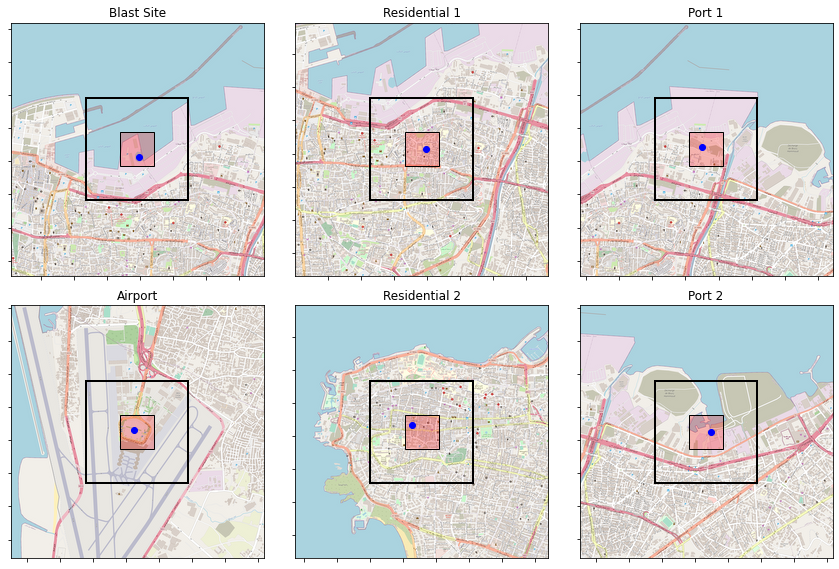

In [18]:
# The next figure will have 6 subplots, one for each point
# 
fc_025 =color.to_rgba('red', 0.25)
fc_000 =color.to_rgba('red', 0.00)

#reordering the list
even = gdf_points2.iloc[::2]  # even
odd =  gdf_points2.iloc[1::2]  # odd

gdf_points2_reorder = even.append(odd)
gdf_points2_reorder

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, ax in enumerate(fig.axes):
    column = gdf_points2_reorder.iloc[i].PoI

    x1 = gdf_points2_reorder.iloc[i].geometry.x
    y1 = gdf_points2_reorder.iloc[i].geometry.y
    
    ax.plot(x1, y1, 'bo')
    
    map_range = 500
        
    x1_degree = gdf_points2_reorder.iloc[i].Longitude
    y1_degree = gdf_points2_reorder.iloc[i].Latitude
        
    NLT_cell, NLT_area = createPolygon(column, y1_degree, x1_degree, check_raster)
    
    patch_cell = patches.PathPatch(NLT_cell, facecolor=fc_025, lw=1)
    ax.add_patch(patch_cell)
    
    patch_area = patches.PathPatch(NLT_area, facecolor=fc_000, lw=2)
    ax.add_patch(patch_area)
    
    
    # Set the limits for the first map
    bbox= NLT_area.get_extents()
    
    ax.set_xlim(bbox.xmin-map_range, bbox.xmax+map_range)
    ax.set_ylim(bbox.ymin-map_range, bbox.ymax+map_range)
    
    map_extent = setExtentDetailedMap(bbox.ymin-map_range, bbox.ymax+map_range, 
                                      bbox.xmin-map_range, bbox.xmax+map_range)
    
    map_plotter = tilemapbase.Plotter(map_extent, tilemapbase.tiles.build_OSM(), width=1500)
    map_plotter.plot(ax=ax)
    
    #removing the tick labels for map3
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(column) #, fontsize='small', loc='left')
    ax.grid(False) #True, color = "black", linewidth = "0.5", linestyle = "-.")

fig.tight_layout()
plt.show()

<h2> Cumulative Contribution Night-Time Light (NTL) Intensity </h2>
To get an idea how the NTL is distributed in Lebanon and Beirut a cummalative sum of the NTL values by cell is calculated. For each GeoTiff raster the NTL is extracted and counted, the count by NTL value is added to the previous values of the raster images. <br>
The result is a list of all unique NTL values in the range [0 - n] for any area of interest. 

In [19]:
#Investigating the NTL intensities
#getting the list of all NTL files

#set the data folder

#check if the function is computed for country level:
filename = "sumCountry_NTL.csv"
filepath = os.path.join(mapDataPath, filename)

#flag to load saved data
booCreateFile = False

if os.path.isfile(filepath):         # the program created the file
    if booCreateFile:                # user want to recreate the file
        print("recreating the file")
else:                                # file is not created 
    booCreateFile = True
    print("creating the file")
        
if booCreateFile:                    # create the file
    outputFolder = os.path.join(pathDataRepo, pathNewTiff)

    os.chdir(outputFolder)
    rasterFiles = [f for f in os.listdir(os.getcwd()) if f.endswith('.tif')]

    df_sumCountry_NTL = createCumSumNTL(gadm36_LBN_0, outputFolder, rasterFiles)
    df_sumCountry_NTL.to_csv(filepath, index = False)

else: #loading the file
    print("reading the file")
    df_sumCountry_NTL = pd.read_csv(filepath)
    


reading the file


In [20]:
df_sumCountry_NTL

,count,index1,cumsum,ratio
0,0.0,0,0.0,0.000000
1,1424187.0,1,1424187.0,0.025163
2,2314329.0,2,3738516.0,0.066054
3,2939640.0,3,6678156.0,0.117993
4,2990838.0,4,9668994.0,0.170836
...,...,...,...,...
15974,0.0,15974,56598016.0,1.000000
15975,0.0,15975,56598016.0,1.000000
15976,0.0,15976,56598016.0,1.000000
15977,0.0,15977,56598016.0,1.000000


In [21]:
#four break points

breakpoints=[0.05, 0.25, 0.75, 0.95]
x_points=[]
y_points=[]

for input in breakpoints:
    
    x_point = int(df_sumCountry_NTL['index1'].iloc[(df_sumCountry_NTL['ratio']-input).abs().argsort()[:1]])
    
    digits = int(math.log10(x_point))+1
    base = 10**(digits-1) # setting the base to 1, 10, 100, 1000
    x_point = roundint(x_point, base, direction="test")
    
    x_points.append(x_point)
    
    y_point = float(df_sumCountry_NTL['ratio'].iloc[(df_sumCountry_NTL['index1']-x_point).abs().argsort()[:1]])
    y_point = round(y_point, 2)
    y_points.append(y_point)
    


In [22]:
x_points

[2, 6, 50, 200]

<h3> Lebanon NTL analysis </h3>
Plotting the cummalative sum of NTL for Lebanon

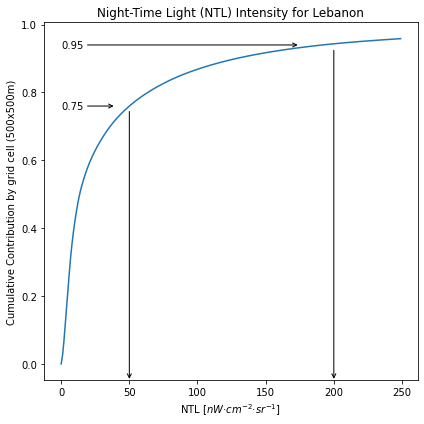

In [23]:


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
ax = sns.lineplot(data=df_sumCountry_NTL[df_sumCountry_NTL['index1']<250], x="index1", y="ratio")

ax.set_xlabel("NTL [$nW·cm ^{{{-2}}}·sr ^{{{-1}}}$]")
ax.set_ylabel("Cumulative Contribution by grid cell (500x500m)")

plt.annotate(text='0.95', xy=(x_points[3]-25,y_points[3]), 
                      xytext=(0,y_points[3]), 
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text='', xy=(x_points[3],y_points[3]-0.01), 
                  xytext=(x_points[3],0-0.05), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.annotate(text='0.75', xy=(x_points[2]-10,y_points[2]), 
                      xytext=(0,y_points[2]), 
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text='', xy=(x_points[2],y_points[2]-0.01), 
                  xytext=(x_points[2],0-0.05), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.title("Night-Time Light (NTL) Intensity for Lebanon")
fig.tight_layout()

<h3> Greater Beirut NTL analysis </h3>
Now doing the same for the Greater beirut Area

In [24]:
#check if the function is computed for country level:
filename = "sumBeirut_NTL.csv"
filepath = os.path.join(mapDataPath, filename)

#flag to load saved data
booCreateFile = False

if os.path.isfile(filepath):         # the program created the file
    if booCreateFile:                # user want to recreate the file
        print("recreating the file")
else:                                # file is not created 
    booCreateFile = True
    print("creating the file")
        
if booCreateFile:                    # create the file
    outputFolder = os.path.join(pathDataRepo, pathNewTiff)

    os.chdir(outputFolder)
    rasterFiles = [f for f in os.listdir(os.getcwd()) if f.endswith('.tif')]

    #setting the Beirut shape
    df_sumBeirut_NTL = createCumSumNTL(gadm36_LBN_3, outputFolder, rasterFiles)
    df_sumBeirut_NTL.to_csv(filepath, index = False)

else: #loading the file
    print("reading the file")
    df_sumBeirut_NTL = pd.read_csv(filepath)
    

reading the file


In [25]:
#four break points

breakpoints=[0.05, 0.25, 0.75, 0.95]
x_points=[]
y_points=[]

for input in breakpoints:
    
    x_point = int(df_sumBeirut_NTL['index1'].iloc[(df_sumBeirut_NTL['ratio']-input).abs().argsort()[:1]])
    
    digits = int(math.log10(x_point))+1
    base = 10**(digits-2) # setting the base to 1, 10, 100, 1000
    x_point = roundint(x_point, base, direction="test")
    
    x_points.append(x_point)
    
    y_point = float(df_sumBeirut_NTL['ratio'].iloc[(df_sumBeirut_NTL['index1']-x_point).abs().argsort()[:1]])
    y_point = round(y_point, 2)
    
    y_points.append(y_point)
    


In [26]:
x_points

[130, 300, 770, 1300]

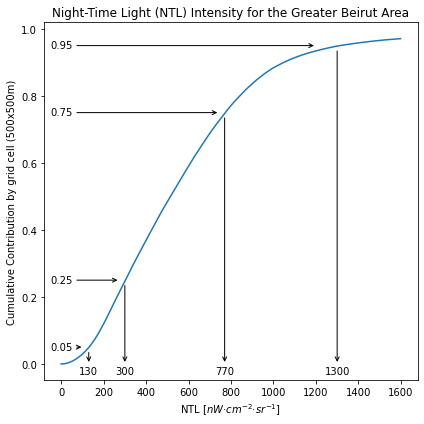

In [27]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
ax = sns.lineplot(data=df_sumBeirut_NTL[df_sumBeirut_NTL['index1']<1600], x="index1", y="ratio")
ax.set_xlabel("NTL [$nW·cm ^{{{-2}}}·sr ^{{{-1}}}$]")
ax.set_ylabel("Cumulative Contribution by grid cell (500x500m)")

plt.annotate(text='0.95', xy=(x_points[3]-100,y_points[3]), 
                      xytext=(0-50,y_points[3]), 
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text=x_points[3], xy=(x_points[3],y_points[3]-0.01), 
                  xytext=(x_points[3],0-0.03), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.annotate(text='0.75', xy=(x_points[2]-25,y_points[2]), 
                      xytext=(0-50,y_points[2]), 
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text=x_points[2], xy=(x_points[2],y_points[2]-0.01), 
                  xytext=(x_points[2],0-0.03), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.annotate(text='0.25', xy=(x_points[1]-25,y_points[1]), 
                      xytext=(0-50,y_points[1]), 
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text=x_points[1], xy=(x_points[1],y_points[1]-0.01), 
                  xytext=(x_points[1],0-0.03), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.annotate(text='0.05', xy=(x_points[0]-25,y_points[0]), 
                      xytext=(0-50,y_points[0]),
             arrowprops=dict(arrowstyle='->'), va='center')
plt.annotate(text=x_points[0], xy=(x_points[0],y_points[0]-0.01), 
                  xytext=(x_points[0],0-0.03), 
             arrowprops=dict(arrowstyle='<-'), ha='center')

plt.title("Night-Time Light (NTL) Intensity for the Greater Beirut Area")


fig.tight_layout()

In [28]:
df_sumBeirut_NTL

,count,index1,cumsum,ratio
0,0.0,0,0.0,0.000000
1,2.0,1,2.0,0.000005
2,4.0,2,6.0,0.000015
3,5.0,3,11.0,0.000028
4,9.0,4,20.0,0.000051
...,...,...,...,...
15974,0.0,15974,392915.0,0.999997
15975,0.0,15975,392915.0,0.999997
15976,0.0,15976,392915.0,0.999997
15977,0.0,15977,392915.0,0.999997


In [29]:
df_sumBeirut_NTL.loc[df_sumBeirut_NTL['index1'] > 5000,['count']].sum(axis=0)

count    324.0
dtype: float64

<h2>NTL intensity directly after the explosion</h2>
The variation in the Greater Beirut Area is large (rangng from 0 to 16000), the plot is giving a summary using all the collected data (between 2015 - 2020 for 05/01 to 10/31), and most the raster cells are registering an illumination, in this area, between 300 and 800. <br>
The hypotesis is that the explosion has an effect on the illumination, therefore looking at the illumination the evening after the blast could give an indication of the direct effect of the explostion (presumed is that there is minimal NTL on this evening)


In [30]:
#Adding the NTL data
date_Start = "2020-08-05"
date_Stop = "2020-08-05"

#set the data folder
outputFolder = os.path.join(pathDataRepo, pathNewTiff)

os.chdir(outputFolder)
rasterFiles = [f for f in os.listdir(os.getcwd()) if f.endswith('.tif')]
rasterFiles.sort()

#select the files for the date range
#plot_type = "historical"
#plot_type = "single"
plot_type = "single"
selectedDates = constructTimeRange(rasterFiles, date_Start, date_Stop, plot_type) # single or historical


rasterFilesLoc = os.path.join(outputFolder, selectedDates.iloc[0]['filenames'])

                                          filenames       dates
1166  VNP46A2_A2020218_h21v05_001_2021076042421.tif  2020-08-05


In [31]:
#Reprojecting the original NTL data
in_proj = "EPSG:4326"
out_proj = "EPSG:3857"

rasterFilesLoc
ds = rxr.open_rasterio(rasterFilesLoc,
                              masked=True).squeeze()
# CHeck the CRS
print(ds.rio.crs)

# Create a rasterio crs object for wgs 84 crs - lat / lon
crs_new = CRS.from_string(out_proj)

# Reproject the data using the crs object
ds_2 = ds.rio.reproject(crs_new)
print(ds_2.rio.crs)


EPSG:4326
EPSG:3857


In [32]:
#Reclassifying, based on the breakpoints detected earlier:
class_bins = [0, 130, 300, 800, 1300, 15000, 65535]
ds_2_class = xr.apply_ufunc(np.digitize,
                            ds_2,
                            class_bins)

#Remove the last class
ds_2_class_ma = ds_2_class.where(ds_2_class != 7)
#ds_2_class_ma

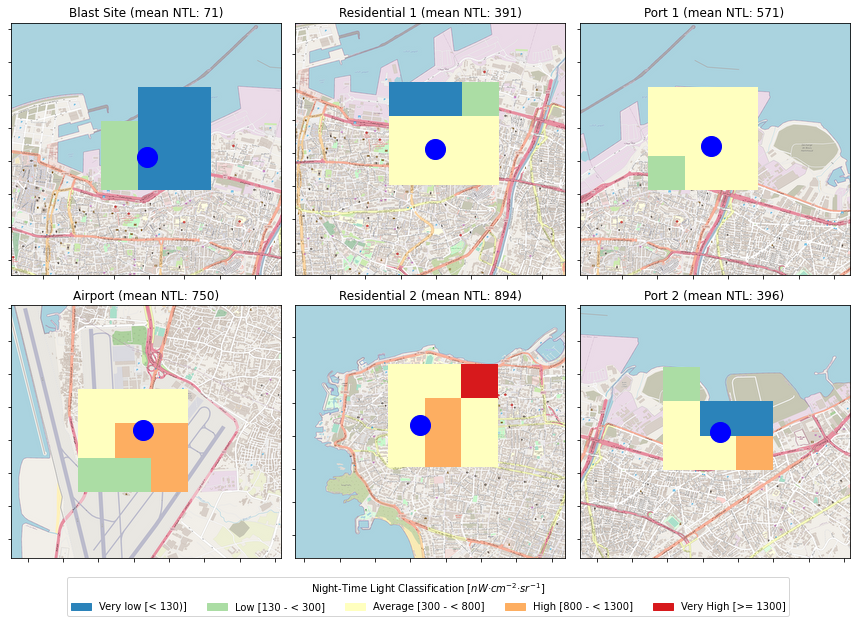

In [33]:
#Making the Plot

#https://www.earthdatascience.org/courses/use-data-open-source-python
#/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/

# The next figure will have 6 subplots, one for each point
# 
# Create a list of labels to use for your legend
#from matplotlib.patches import Patch

height_class_labels = ["Very low [< 130)]",
                       "Low [130 - < 300]",
                       "Average [300 - < 800]",
                       "High [800 - < 1300]",
                       "Very High [>= 1300]"] #,
                      #"No Data"]

# Create a colormap from a list of colors
colors = ['#2b83ba',
            '#abdda4',
            '#ffffbf',
            '#fdae61',
            '#d7191c']#,
            #'#d7191c00'] #transparent because of ending on "00"

class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))


# using dictionary comprehension
# to convert lists to dictionary
legend_labels = {colors[i]: height_class_labels[i] for i in range(len(colors))}


from matplotlib.lines import Line2D
marker_style = dict(color='tab:red', linestyle=':', marker='s',
                    markerfacecoloralt='tab:red')


fc_025 =color.to_rgba('red', 0.25)
fc_000 =color.to_rgba('red', 0.00)

#reordering the list
even = gdf_points2.iloc[::2]  # even
odd =  gdf_points2.iloc[1::2]  # odd

gdf_points2_reorder = even.append(odd)
gdf_points2_reorder


fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, ax in enumerate(fig.axes):
    column = gdf_points2_reorder.iloc[i].PoI

    x1 = gdf_points2_reorder.iloc[i].geometry.x
    y1 = gdf_points2_reorder.iloc[i].geometry.y
    
    ax.plot(x1, y1, 'bo', markersize=20)
    #ax.plot(x1, y1, 's', markersize=150, **marker_style, fillstyle="none")
    
    map_range = 500
        
    x1_degree = gdf_points2_reorder.iloc[i].Longitude
    y1_degree = gdf_points2_reorder.iloc[i].Latitude
        
    NLT_cell, NLT_area = createPolygon(column, y1_degree, x1_degree, check_raster)
    patch_cell = patches.PathPatch(NLT_cell, facecolor=fc_025, lw=1)
    #ax.add_patch(patch_cell)
    
    patch_area = patches.PathPatch(NLT_area, facecolor=fc_000, lw=2)
    #ax.add_patch(patch_area)
    
    
    # Set the limits for the first map
    bbox= NLT_area.get_extents()
    
    ax.set_xlim(bbox.xmin-map_range, bbox.xmax+map_range)
    ax.set_ylim(bbox.ymin-map_range, bbox.ymax+map_range)
    
    map_extent = setExtentDetailedMap(bbox.ymin-map_range, bbox.ymax+map_range, 
                                      bbox.xmin-map_range, bbox.xmax+map_range)
    
    
    map_plotter = tilemapbase.Plotter(map_extent, tilemapbase.tiles.build_OSM(), width=1500)
    map_plotter.plot(ax=ax)
    
    #masking the areas outside the 3x3 area
    mask_lon = (ds_2_class_ma.x>= bbox.xmin) & (ds_2_class_ma.x <= bbox.xmax)
    mask_lat = (ds_2_class_ma.y >= bbox.ymin) & (ds_2_class_ma.y <= bbox.ymax)

    cropped_ds = ds_2_class_ma.where(mask_lon & mask_lat, drop=True)
    
    cropped_ds.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
    
    cropped_ds2 = ds_2.where(mask_lon & mask_lat, drop=True)
    cropped_ds2 = cropped_ds2.where(cropped_ds2<=10000, drop=True)
    #print(cropped_ds)
    area_mean = (int(cropped_ds2.mean()))
    
    
                
    #removing the tick labels for map3
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    title_txt = "{sArea} (mean NTL: {meanNTL})".format(sArea = column, meanNTL = area_mean)
    ax.set_title(title_txt) #, fontsize='small', loc='left')
    
    ax.grid(False) #True, color = "black", linewidth = "0.5", linestyle = "-.")

    
fig_patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

fig.legend(title=r'Night-Time Light Classification [$nW·cm ^{{{-2}}}·sr ^{{{-1}}}$]',
           handles=fig_patches,
           facecolor="white",
           loc='upper center', ncol =6, fancybox=True,
           bbox_to_anchor=(0.5, 0),)

   
fig.tight_layout()


plt.show()


At the night after the explosion the NTL is indeed the lowest in area directly (the 3x3 cell window) around the blast site, damage is reported in the areas south and east from the site, and residential area 1 is reporting less than average NTL, the other sites are brightly illuminated at this night. 

<h2> Night-Time Light (NTL) by Site </h2>
Knowing the overal light intensity over the greater Beirut Area is useful, it confirms that the VIIRS data could be used for this analysis. Beirut is the brightest area in Lebanon, but also has the largerst spread of intensities. Extracting the NTL by the six sites will show how large this variation is in the selected time period, and on the night directly after the explosion. <br>
Having only one timestamp is not enough to draw a conclusion of the effect of the explosion, the next plots are looking at the NTL data by year, and at the months arond the explosion (2020) to get a better understanding of the behaviour of NTL in the selected locations. 

In [34]:
# Select the data ranges
# Available years: 2015 - 2021
# dates: 05-01 to 10-31 (ending at 2021-02-29)
# date_string = "2020-08-01"

date_Start = "2020-05-01"
date_Stop = "2020-10-31"

In [35]:
#set the data folder
outputFolder = os.path.join(pathDataRepo, pathNewTiff)

os.chdir(outputFolder)
rasterFiles = [f for f in os.listdir(os.getcwd()) if f.endswith('.tif')]
rasterFiles.sort()

#select the files for the date range
#plot_type = "historical"
#plot_type = "single"
plot_type = "all"
selectedDates = constructTimeRange(rasterFiles, date_Start, date_Stop, plot_type) # single or historical

totalFiles = len(selectedDates)
DNBvalue1 = []
DNBvalue3 = []
JD = []

year = selectedDates.iloc[0]['dates'].year
print("Long Process") #Latitude	Longitude
for x, y, label in zip(gdf_points2.Longitude, gdf_points2.Latitude, gdf_points2.PoI):
    print(label)
    #print("   ", year)
    i = 0
    for i in range(0, totalFiles):
        #if selectedDates.iloc[i]['dates'].year != year:
        #    year = selectedDates.iloc[i]['dates'].year
        #    #print("   ", year)
        #
        #if not JD:
        #    #print("   ", year)
            
        JD.append(selectedDates.iloc[i]['dates'])

        rasterFilesLoc = os.path.join(outputFolder, selectedDates.iloc[i]['filenames'])

        DNBvalue3.append(getRasterData(rasterFilesLoc, y, x, 3))
    
print("files:   ", len(DNBvalue3))

#setting up the DataFrame
B = np.reshape(DNBvalue3,(-1,6), order='F')
df_NTL = pd.DataFrame(data=B)
df_NTL[df_NTL == 0.0] = np.nan
df_NTL[df_NTL == 5000.0] = np.nan

df_NTL.rename(columns={0: gdf_points2.loc[0].PoI, 
                       1: gdf_points2.loc[1].PoI,
                       2: gdf_points2.loc[2].PoI, 
                       3: gdf_points2.loc[3].PoI, 
                       4: gdf_points2.loc[4].PoI,
                       5: gdf_points2.loc[5].PoI}, inplace=True)

df_NTL['index1'] = df_NTL.index

#Working with the dates:
df_NTL['date'] = JD[0:len(B)]
df_NTL['date'] = pd.to_datetime(df_NTL['date'])
df_NTL.set_index('date', inplace=True)
df_NTL['year'] = df_NTL.index.year
df_NTL['WoY'] = df_NTL.index.isocalendar().week
df_NTL['DoY'] = df_NTL.index.dayofyear

df_NTL.loc['2020-08-04':, 'Event'] = 1
df_NTL['Event'] = df_NTL['Event'].fillna(0)

print("data ready")


Long Process
Blast Site
Airport
Residential 1
Residential 2
Port 1
Port 2
files:    6624
data ready


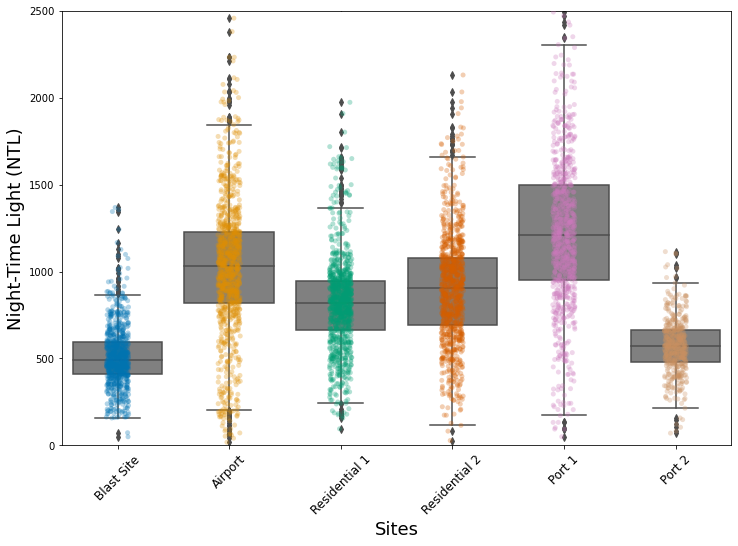

In [36]:
xaxisLables = gdf_points2.PoI.tolist()



fig, ax = plt.subplots(figsize=(12,8))
# make stripplot
bp = sns.stripplot(data=df_NTL.iloc[:, 0:6], ax=ax, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.3,
                   palette="colorblind",)

# make boxplot
bp = sns.boxplot(data=df_NTL.iloc[:, 0:6], ax=ax,
                 color='grey')
bp.set(ylim=(0, 2500))

ax.set_xlabel('Sites', fontsize=18)
ax.set_ylabel('Night-Time Light (NTL)', fontsize=18)

xtickNames = plt.setp(ax, xticklabels=xaxisLables)
plt.setp(xtickNames, rotation=45, fontsize=12)

plt.show()

<h2>Night-Time Light (NTL) by Site and by Year </h2>
There is high variability in the data, but the plot doesn't show any trends within the sites. The next plot will give a breakdown by year.

In [37]:
# Reorganising the data to show the distribution by year;
# the column names are removed in the final data frame
df_NTL_copy = df_NTL.copy() #getting a copy
df_NTL_copy.rename(columns={"Blast Site": "A1", 
                       "Airport": "B2",
                       "Residential 1": "C3", 
                       "Residential 2": "D4", 
                       "Port 1": "E5",
                       "Port 2": "F6"}, inplace=True)

df_NTL_copy["id"] = df_NTL_copy.index
df_NTL_sites = pd.wide_to_long(df_NTL_copy, ["A", "B","C", "D","E", "F"], i="id", j="site")

df_NTL_sites.reset_index(inplace=True)

df_NTL_sites['NTL']= df_NTL_sites.iloc[:, -6:].sum(axis=1)

df_NTL_sites.drop(["A", "B","C", "D","E", "F"], axis=1 ,inplace=True )

df_NTL_sites["NTL"] = df_NTL_sites["NTL"].replace(0, np.nan)


In [38]:
#df_NTL_sites

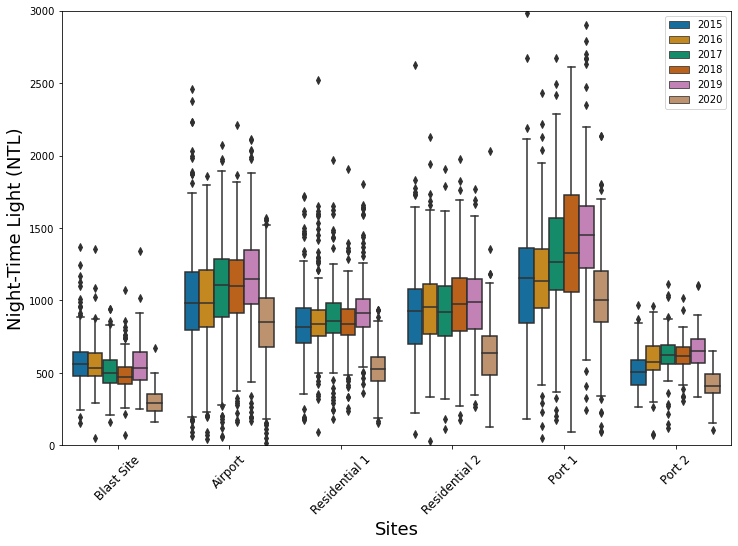

In [39]:
#https://cmdlinetips.com/2019/03/how-to-make-grouped-boxplots-in-python-with-seaborn/
xaxisLables = gdf_points2.PoI.tolist()

fig, ax = plt.subplots(figsize=(12,8))
# make grouped boxplot
bp = sns.boxplot(y='NTL', x='site', 
                 data=df_NTL_sites, 
                 palette="colorblind",
                 hue='year',
                 ax = ax)

bp.set(ylim=(0, 3000)) #change because of higher variation by year

ax.set_xlabel('Sites', fontsize=18)
ax.set_ylabel('Night-Time Light (NTL)', fontsize=18)

# get legend information from the plot object
handles, labels = bp.get_legend_handles_labels()

# specify just one legend
labels = labels[0:6]
labels = [s.replace(".0", "") for s in labels]
l = plt.legend(handles[0:6], labels)

xtickNames = plt.setp(ax, xticklabels=xaxisLables)
plt.setp(xtickNames, rotation=45, fontsize=12)

plt.show()


<h2>Blast Site by year</h2>
Seeing the siz sites sumaries by year clearly shows that 2020 is a different year to the other years. The graph doesn't show how different the year is, nor how much variation there is between daily/weekly NTL observations. To see this the data has to be reformated to allow for a time series plot. There is a lot of variations between the observations, to still have a readable plot the data in the next section is averaged by week.

In [40]:
# data preparation
df_NTL_copy2= df_NTL.copy() #getting a copy
df_NTL_copy2.drop(["index1", "year", "WoY", "DoY", "Event"], axis=1 ,inplace=True )
#df_NTL_copy2

In [51]:
#set up the weekly dataframe:
weekly_summary = pd.DataFrame()
weekly_summary = df_NTL_copy2.resample('W').mean()
yearly_summary = df_NTL_copy2.resample('Y').mean()
yearly_summary["Blast Site"][0:-1].mean()

549.8268745338735

In [42]:
# recreating the same structure as in the previous graph, so that the 
# plot can be made for each site with a simple filter, instead of by 
# using the column name
weekly_summary.rename(columns={"Blast Site": "A1", 
                       "Airport": "B2",
                       "Residential 1": "C3", 
                       "Residential 2": "D4", 
                       "Port 1": "E5",
                       "Port 2": "F6"}, inplace=True)

In [46]:
weekly_summary["week date"] = weekly_summary.index
df_NTL_sites_weekly = pd.wide_to_long(weekly_summary, 
                                      ["A", "B","C", "D","E", "F"], 
                                      i="week date", 
                                      j="site")

df_NTL_sites_weekly.reset_index(inplace=True)

df_NTL_sites_weekly['NTL']= df_NTL_sites_weekly.iloc[:, -6:].sum(axis=1)

df_NTL_sites_weekly.drop(["A", "B","C", "D","E", "F"], axis=1 ,inplace=True )

df_NTL_sites_weekly[df_NTL_sites_weekly == 0.0] = np.nan

#adding the year and week number
df_NTL_sites_weekly['Year'] = pd.DatetimeIndex(df_NTL_sites_weekly["week date"]).year
df_NTL_sites_weekly['WoY'] = np.array(pd.DatetimeIndex(df_NTL_sites_weekly["week date"]).isocalendar().week)
#df_NTL_sites_weekly

In [58]:
# making boolean series from the site number
filter = df_NTL_sites_weekly["site"]==1
  
# filtering data
data = df_NTL_sites_weekly[filter]
  
# display, to see the week numbers closest to the event
date_Start = "2020-07-20"
date_Stop = "2020-08-20"
mask = (data['week date'] > date_Start) & (data['week date'] <= date_Stop)
data.loc[mask]



,week date,site,NTL,Year,WoY
1638,2020-07-26,1,268.888,2020,30
1644,2020-08-02,1,206.934,2020,31
1650,2020-08-09,1,205.165,2020,32
1656,2020-08-16,1,234.870,2020,33


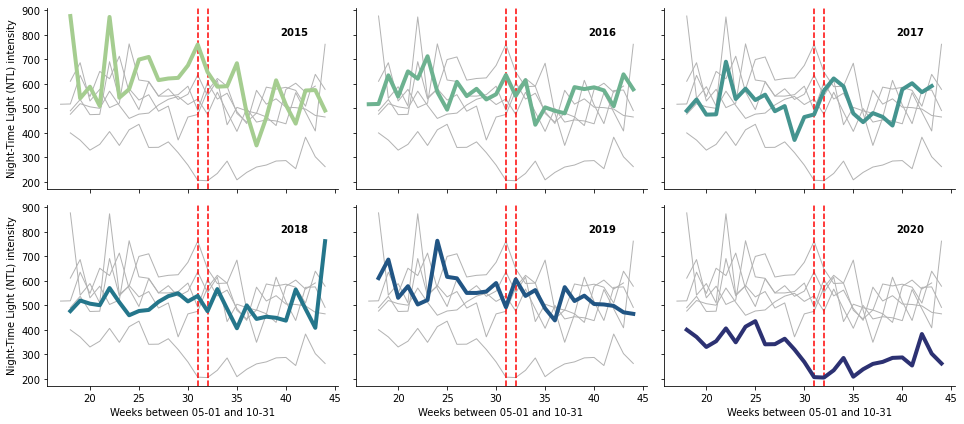

In [45]:
# 78	2015-08-02	1	761.091667	2015	31
# 84	2015-08-09	1	648.826000	2015	32

g = sns.relplot(
    data=data,
    x="WoY", y="NTL", col="Year", hue="Year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=data, x="WoY", y="NTL", units="Year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.axvline(x=31, ymin=0, ymax=1400, ls='--', color='red')
    ax.axvline(x=32, ymin=0, ymax=1400, ls='--', color='red')

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Weeks between 05-01 and 10-31", "Night-Time Light (NTL) intensity")
g.tight_layout()

The NTL is very variable between weeks, but the yearly average for this site is stable around 550 nWatts·cm<sup>−2</sup>·sr<sup>−1</sup>, except for 2020 where the average for this period is around 300 nWatts·cm<sup>−2</sup>·sr<sup>−1</sup>

<h2>NTL for all sites in 2020</h2>
This study is not about the NTL propagation over time, but is focussing esspecially on the time before and after the explosion. In the figure above the NTL has the lowest NTL value in the week of the explosion (205 nWatts·cm−2·sr−1), and the NTL seems to be slowly recovering after this point, but the decline started in the weeks before, around the beginning of Juli, so it is not clear if the explosion contributed to this low NTL, and if it did with how much it contributed.
To (visually) inspect the NTL for 2020 over the other sites the last image (2020) is recreated for the other sites.

In [59]:
# making boolean series for a team name
filter = df_NTL_sites_weekly["Year"]==2020
  
# filtering data
data = df_NTL_sites_weekly[filter]
  


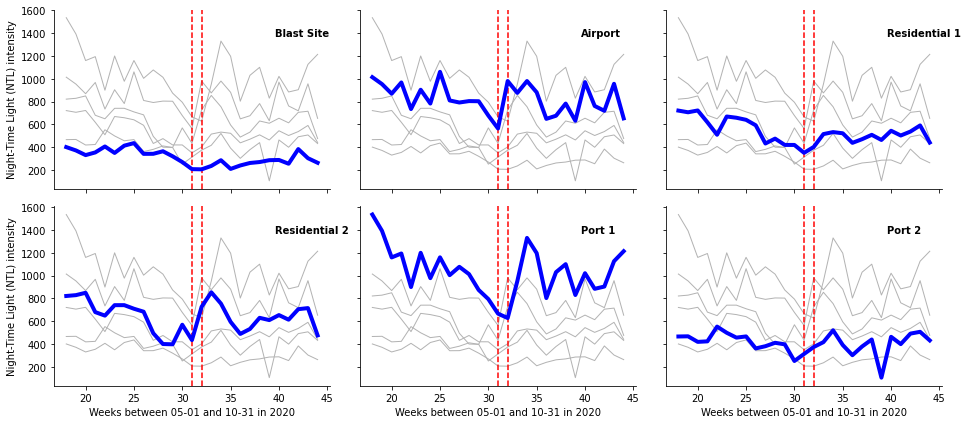

In [60]:
g = sns.relplot(
    data=data,
    x="WoY", y="NTL", col="site", hue="site",
    kind="line", palette=["b","b","b","b","b","b" ], linewidth=4, zorder=5,
    col_wrap=3, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for site, ax in g.axes_dict.items():
    site = int(site)-1
    label = gdf_points2.iloc[site].PoI
    
    # Add the title as an annotation within the plot
    ax.text(.8, .85, label, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=data, x="WoY", y="NTL", units="site",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    ax.axvline(x=31, ymin=0, ymax=1400, ls='--', color='red')
    ax.axvline(x=32, ymin=0, ymax=1400, ls='--', color='red')

# Reduce the frequency of the x axis ticks
#ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Weeks between 05-01 and 10-31 in 2020", "Night-Time Light (NTL) intensity")
g.tight_layout()

The airport and the port 1 area have both an extreem minimum at the time of the explosion, residential area 1 (closest to the blst location) is recovering from a minimum NTL period, as well as residential area 2. The port area 2 is stable, with one extreem minimum much later. From these ilustrations it is not clear if there is an (visable) effect in the NTL values, caused by the exlosion.

In [95]:
# preparing the data for the plot, splitting the 2020 data to 
# dates before and after the event
data_copy = data.copy()

#moving the Airport to the end of the graph
# 1 = 1
# 2 = 7 = 5
# 3 = 2
# 4 = 4
# 5 = 3
# 6 = 6

mask = (data_copy["site"] == 2)
data_copy.loc[mask, "site"] = 9
mask = (data_copy["site"] == 5)
data_copy.loc[mask, "site"] = 10
mask = (data_copy["site"] == 4)
data_copy.loc[mask, "site"] = 8
mask = (data_copy["site"] == 5)
data_copy.loc[mask, "site"] = 7

data_copy.sort_values(by=["WoY", "site"], inplace=True)

event_date = '2020-08-04'
mask = (data['week date'] >= event_date)

data_copy.loc[mask, "Event"] = 1
data_copy['Event'] = data_copy['Event'].fillna(0)

data_copy.dropna(subset=["NTL"], inplace=True)  # col_list is a list of column names to consider for nan values.

data_copy #.describe()

,week date,site,NTL,Year,WoY,Event
1566,2020-05-03,1,400.275000,2020,18,0.0
1568,2020-05-03,3,720.706667,2020,18,0.0
1571,2020-05-03,6,465.780000,2020,18,0.0
1569,2020-05-03,8,821.333333,2020,18,0.0
1567,2020-05-03,9,1014.036667,2020,18,0.0
...,...,...,...,...,...,...
1724,2020-11-01,3,440.222500,2020,44,1.0
1727,2020-11-01,6,431.333333,2020,44,1.0
1725,2020-11-01,8,475.447500,2020,44,1.0
1723,2020-11-01,9,652.445000,2020,44,1.0


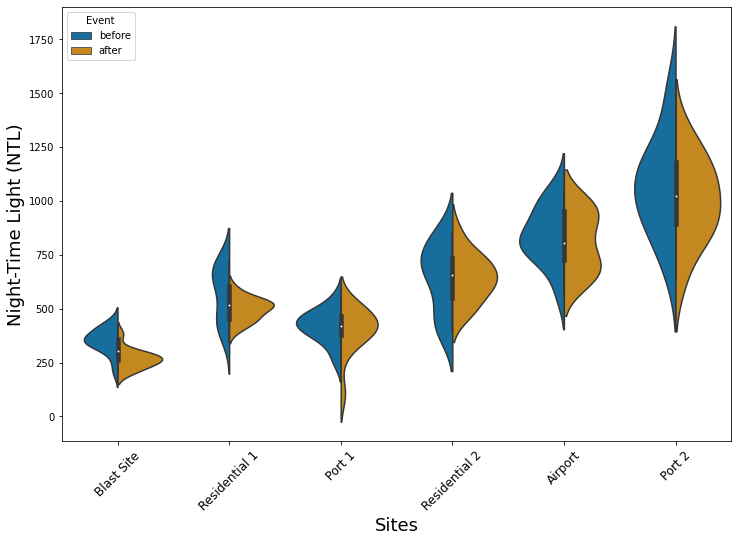

In [98]:
#getting the axis labels and reorder
#xaxisLables = gdf_points2.PoI.tolist()
#xaxisLables.append(xaxisLables.pop(xaxisLables.index('Airport')))
xaxisLables = ['Blast Site', 
               'Residential 1', 
               'Port 1', 
               'Residential 2', 
               'Airport', 
               'Port 2']

strTitle = "Event"

fig, ax = plt.subplots(figsize=(12,8))
# make grouped violin plot
vp = sns.violinplot(x="site", 
                    y="NTL", 
                    hue="Event", 
                    data=data_copy, 
                    palette="colorblind", 
                    split=True,
                    ax = ax)

ax.set_xlabel('Sites', fontsize=18)
ax.set_ylabel('Night-Time Light (NTL)', fontsize=18)

# get legend information from the plot object
handles, labels = vp.get_legend_handles_labels()

# specify just one legend
labels = ["before", "after"]
l = plt.legend(handles, labels, title = strTitle, loc='upper left')

xtickNames = plt.setp(ax, xticklabels=xaxisLables)
plt.setp(xtickNames, rotation=45, fontsize=12)

plt.show()

From the six sites only the Blast Site and the Residential 1 Area have a "significanly" different distribution when the weekly averages after the event are compared to the values before the event. The question is are the values statisticly significantly different. 



<h1>Statistical testing</h1>
To test the difference between after the explosion to the time before the explosion (in the same year) several tests are available. The most simple test is a T-Test, but also the xxx, xxx, and xxx are quickly checked (without going into to much detail). Finally, the "CausalImpact" a test developed by Google, is used to look in depth at the time around the explosion, and test for causality, e.g. if the explosion had a significant effect on the NTL

<h2> Three simple Tests</h2>